In [1]:
import sys
sys.path.append("/scratch/m/murray/dtolgay/")
from tools import functions_readfiles as readfiles # type: ignore
from tools import constants # type: ignore

import numpy as np
import pandas as pd 

import h5py # type: ignore

import matplotlib.pyplot as plt # type: ignore

In [2]:
def read_gas_particles_from_hdf5(file_path: str) -> pd.DataFrame:
    
    with h5py.File(file_path, 'r') as f:
        part_group = f['PartType0']

        # Load vector quantities
        p = part_group['p'][:]   # shape (N, 3)
        v = part_group['v'][:]

        # Load scalar quantities
        m = part_group['m'][:]
        rho = part_group['rho'][:]
        h = part_group['h'][:]
        sfr = part_group['sfr'][:]
        u = part_group['u'][:]
        T = part_group['T'][:]
        hden = part_group['hden'][:]
        isrf = part_group['isrf_skirt'][:] 
        z = part_group['z'][:]          # shape (N, 11)

    # Build dataframe
    df = pd.DataFrame({
        'x': p[:, 0],
        'y': p[:, 1],
        'z': p[:, 2],
        'vx': v[:, 0],
        'vy': v[:, 1],
        'vz': v[:, 2],
        'mass': m,
        'density': rho,
        'smoothing_length': h,
        'star_formation_rate': sfr,
        'internal_energy': u,
        'temperature': T,
        'hden': hden,
        'isrf': isrf,
        'metallicity': z[:, 0],
        'He_mass_fraction': z[:, 1],
        'C_mass_fraction': z[:, 2],
        'N_mass_fraction': z[:, 3],
        'O_mass_fraction': z[:, 4],
        'Ne_mass_fraction': z[:, 5],
        'Mg_mass_fraction': z[:, 6],
        'Si_mass_fraction': z[:, 7],
        'S_mass_fraction': z[:, 8],
        'Ca_mass_fraction': z[:, 9],
        'Fe_mass_fraction': z[:, 10],
    })

    return df


def combine_chimes_hdf5_files(path_to_chimes_file: str, gas_particles_before_chimes: pd.DataFrame) -> pd.DataFrame:

    with h5py.File(path_to_chimes_file, 'r') as f:
        after_chimes = f['EqmChemistryAbundances'][:]  # Load the dataset into a NumPy array

    chimes = gas_particles_before_chimes.copy()

    nco_over_nh = after_chimes[:, 148]  # Get all rows of column 148
    nh2_over_nh = after_chimes[:, 137]  # Get all rows of column 137

    # Calculate the mass fraction of H2 and CO
    chimes['fCO'] = nco_over_nh * constants.mco_molecular_mass 
    chimes['fH2'] = nh2_over_nh * constants.mh2_molecular_mass

    # Determine the volume of each particle
    chimes['volume'] = chimes['mass'] / (chimes['density'] * constants.gr2M_sun) # cm3

    # Calculate the number density of H2 and CO
    chimes['density_h2'] = chimes['density'] / constants.mu_h  * chimes['fH2'] # gr/cm3
    chimes['density_co'] = chimes['density'] / constants.mu_h  * chimes['fCO'] # gr/cm3

    # Calculate the mass of H2 and CO 
    chimes['mass_h2'] = chimes['density_h2'] * chimes['volume'] # gr
    chimes['mass_co'] = chimes['density_co'] * chimes['volume'] # gr

    return chimes 

In [3]:
galaxy_name = "gal0"
galaxy_type = "firebox"
redshift = "0.0"
directory_name = "voronoi_1e6"
base_fdir = "/scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/hdf5_files"

In [10]:
# Read the hdf5 file 
hdf5_file_path = f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/{galaxy_name}.hdf5"
print(f"Before chimes file path: {hdf5_file_path}")
before_chimes = read_gas_particles_from_hdf5(file_path = hdf5_file_path)

path_to_chimes_file = f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/gal0_chimes_B87x1.hdf5"
chimes_B87x1 = combine_chimes_hdf5_files(path_to_chimes_file=path_to_chimes_file, gas_particles_before_chimes=before_chimes.copy())

path_to_chimes_file = f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/gal0_chimes_B87x0.1.hdf5"
chimes_B87x01 = combine_chimes_hdf5_files(path_to_chimes_file=path_to_chimes_file, gas_particles_before_chimes=before_chimes.copy())

path_to_chimes_file = f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/gal0_chimes_B87x0.5.hdf5"
chimes_B87x05 = combine_chimes_hdf5_files(path_to_chimes_file=path_to_chimes_file, gas_particles_before_chimes=before_chimes.copy())

Before chimes file path: /scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/hdf5_files/firebox/z0.0/gal0/gal0.hdf5


In [7]:
# Read the gas particles 

base_dir = "/scratch/m/murray/dtolgay/post_processing_fire_outputs/skirt/runs_hden_radius"
file_name = "abundance_RBFInterpolator_smoothingLength.txt"
fdir = f'{base_dir}/{galaxy_type}/z{redshift}/{galaxy_name}/{directory_name}/{file_name}'

cloudy, file_specific_columns = readfiles.read_interpolated_files_usingFilePath(path = fdir, interpolation_type="abundance")

# Calculate mass densities
cloudy['density_h2'] = cloudy['density'] / constants.mu_h  * cloudy['fh2'] # gr/cm3
cloudy['density_co'] = cloudy['density'] / constants.mu_h  * cloudy['fCO'] # gr/cm3

# calcuulate the mass 
cloudy['volume'] = cloudy['mass'] / (cloudy['density'] * constants.gr2M_sun) # cm3
cloudy['mass_h2'] = cloudy['density_h2'] * cloudy['volume'] # gr
cloudy['mass_co'] = cloudy['density_co'] * cloudy['volume'] # gr


In [ ]:
# plt.figure()
# plt.hist(np.log10(cloudy['density']), bins=100, color='blue', alpha=1, label='density')
# plt.hist(np.log10(chimes_B87x1['density']), bins=100, color='red', alpha=0.5, label='density chimes')
# plt.plot()

# plt.figure()
# plt.hist(np.log10(cloudy['mass']), bins=100, color='blue', alpha=1, label='density')
# plt.hist(np.log10(chimes_B87x1['mass']), bins=100, color='red', alpha=0.5, label='density chimes')
# plt.plot()

# print("cloudy: ", np.mean(cloudy['volume']), np.std(cloudy['volume']))

# # Calculating the volume of the hdf5 files 
# cloudy['volume'] = cloudy['mass'] / (cloudy['density'] * constants.gr2M_sun) # cm3
# chimes_B87x1['volume'] = chimes_B87x1['mass'] / (chimes_B87x1['density'] * constants.gr2M_sun) # cm3


# plt.figure()
# plt.hist(np.log10(cloudy['volume']), bins=100, color='blue', alpha=1, label='density')
# plt.hist(np.log10(chimes_B87x1['volume']), bins=100, color='red', alpha=0.5, label='density chimes')
# plt.plot()

# print("chimes: ", np.mean(chimes_B87x1['volume']), np.std(chimes_B87x1['volume']))

In [11]:
print(f"cloudy: {sum(cloudy['mass_co'])}")
print(f"chimes_B87x1: {sum(chimes_B87x1['mass_co'])}")
print(f"chimes_B87x0.5: {sum(chimes_B87x05['mass_co'])}")
print(f"chimes_B87x0.1: {sum(chimes_B87x01['mass_co'])}")


cloudy: 5.427188498908668e+40
chimes_B87x1: 1.5939162366081691e+41
chimes_B87x0.5: 1.5939750455128416e+41
chimes_B87x0.1: 1.5939522612781306e+41


/gpfs/fs0/scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


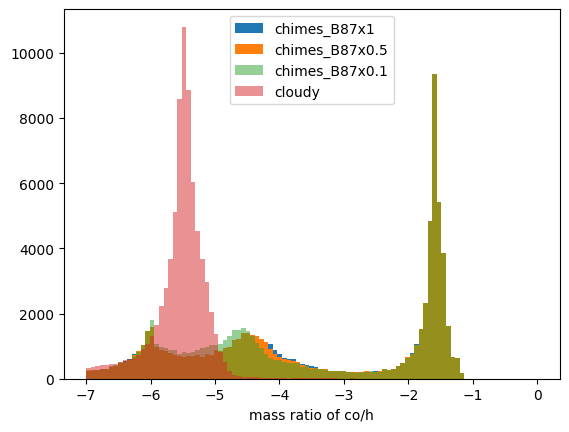

In [13]:
bins = np.linspace(-7, 0, num=100)
plt.hist(np.log10(chimes_B87x1['fCO']), bins=bins, label="chimes_B87x1")
plt.hist(np.log10(chimes_B87x05['fCO']), bins=bins, label="chimes_B87x0.5")
plt.hist(np.log10(chimes_B87x01['fCO']), bins=bins, alpha=0.5, label="chimes_B87x0.1")
plt.hist(np.log10(cloudy['fCO']), bins=bins, alpha=0.5, label="cloudy")
plt.legend()
plt.xlabel("mass ratio of co/h")
plt.show()

# Compare the other properties of hdf5 file and interpolated file 

In [ ]:
# Histogram plots of the centers 
centers = {
    # "metallicity": {
    #     "min": -4.0,
    #     "max": 1,
    #     "ratio": 10**(1.48)
    # },
    # "hden": {
    #     "min": -4.0,
    #     "max": 4.0,
    #     "ratio": 10**(0.55)                        
    # },
    # "isrf": {
    #     "min": -4.0,
    #     "max": 4.0,
    #     "ratio": 10**(-1.73)        
    # },
    # "smoothing_length": {
    #     "min": 0.8,
    #     "max": 3.5
    # },
    "density": {
        "min": -27.0,
        "max": -19.7,
        "ratio": 10**(0.65)                
    },
    "volume": {
        "min": 59, 
        "max": 65,
    },
    "mass": {
        "min": 4,
        "max": 5.3,
    }
}


for column in centers.keys(): 
    plt.figure()

    bins = np.linspace(start=centers[column]['min'], stop=centers[column]['max'], num=200)

    plt.hist(np.log10(cloudy[column]), label="cloudy", bins=bins, alpha=1)
    plt.hist(np.log10(chimes_B87x1[column]), label="chimes_B87x1", bins=bins, alpha=0.5)
    plt.hist(np.log10(chimes_B87x01[column]), label="chimes_B87x0.1", bins=bins, alpha=0.5)
    plt.legend()
    plt.xlabel(f"log10({column})")

        
    plt.show()